# Latent Dirichlet Allocation and Dimension Reduction for Crime Topic Analysis

### See LDA_tests.ipnb for References/Useful Links

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import seaborn as sns
from datetime import datetime
import random

In [2]:
# import topic modeling libraries
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [3]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [4]:
def visualize_model(model, corpus, dictionary):
    return pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)

In [5]:
# import merged df with tokenized first- and second-charge descriptions (from topic_modeling.ipynb)
merged_filt = pd.read_csv('merged_filt.csv')
merged_filt_new = pd.read_csv('merged_filt_NEW.csv')
merged_filt.head()

,Unnamed: 0,id,name,race,c_charge_desc,tokenized_stemmed description,two_year_recid,r_charge_desc,r_tokenized_stemmed description
0,0,1,miguel hernandez,Other,Aggravated Assault w/Firearm,"aggrav, assault, firearm",0,NaN,NaN
1,1,3,kevon dixon,African-American,Felony Battery w/Prior Convict,"feloni, batteri, prior, convict",1,Felony Battery (Dom Strang),"feloni, batteri, domest, strangul"
2,2,4,ed philo,African-American,Possession of Cocaine,"possess, cocain",1,Driving Under The Influence,"drive, influenc"
3,3,5,marcu brown,African-American,Possession of Cannabis,"possess, cannabi",0,NaN,NaN
4,4,6,bouthy pierrelouis,Other,arrest case no charge,"arrest, case, charg",0,NaN,NaN


In [6]:
# get tokenized_stemmed descs as list and put in proper format (list of lists)
def get_tokenized_descs(df, col_label):
    tokenized = df[df[col_label].isna() == False][col_label].tolist()
    tokenized = [desc.split(', ') for desc in tokenized]
    return tokenized

In [7]:
# combine tokenized decsc for first and second offense
def get_all_tokenized_descs(df):
    tokenized = get_tokenized_descs(df, 'tokenized_stemmed description')
    r_tokenized = get_tokenized_descs(df, 'r_tokenized_stemmed description')
    tokenized.extend(r_tokenized)
    return tokenized

In [8]:
# build a dictionary with token --> frequency mappings (for reference and filter_extremes settings)
def get_token_freq_dict(tokenized):
    token_freq = {}
    for d in tokenized:
        for t in d:
            if t not in token_freq:
                token_freq[t] = 1
            else:
                token_freq[t] += 1

In [9]:
def build_dict_corpus(tokenized_, filter_ext):
    # create a dictionary representation of documents (charge descriptions)
    dictionary = Dictionary(tokenized_)

    if filter_ext: 
        dictionary.filter_extremes(no_below=3, no_above=0.5)

    # create a BoW representation of the documents
    corpus = [dictionary.doc2bow(desc) for desc in tokenized_]
    
    return dictionary, corpus

In [10]:
def dict_corpus_stats(dictionary, corpus):
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

In [11]:
def train_lda(random_state, dictionary, corpus, k):
    # set training parameters 
    num_topics = k
    chunksize = 10000
    passes = 20
    iterations = 400
    eval_every = 1

    temp = dictionary[0]
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        random_state=random_state
    )
    return model

In [12]:
# call when want to clear list of trained models
def empty_model_list(trained_models=None, clear=False):
    if clear: trained_models = []
    return trained_models

In [13]:
def train_multiple_models(dictionary, corpus, trained_models, num_train, k):

    start = datetime.now()

    current_time = start.strftime("%H:%M:%S")
    print("START TIME =", current_time)

    offset = len(trained_models)
    for i in range(num_train):
        print('training model ' + str(i + offset) + '...')
        m = train_lda(i + offset, dictionary, corpus, k)
        trained_models.append(m)
    print('done.')

    end = datetime.now()

    current_time = end.strftime("%H:%M:%S")
    print("END TIME =", current_time)

    print('new models trained:', num_train)
    print('total models trained:', len(trained_models))
    return trained_models

In [14]:
def get_model_info(trained_models, dictionary, corpus, random_seed):
    n = random_seed
    model = trained_models[n]
    pprint(model.print_topics())
    return visualize_model(model, corpus, dictionary)

In [15]:
# using new merged_filt --  FILTER EXTREMES -- APRIL 11
tokenized_f = get_all_tokenized_descs(merged_filt_new)
dictionary_f, corpus_f = build_dict_corpus(tokenized_f, filter_ext=True)
dict_corpus_stats(dictionary_f, corpus_f)
trained_models_f = empty_model_list(trained_models=None,clear=True)
print('# trained models:', len(trained_models_f))
num_train = 10
trained_models_f = train_multiple_models(dictionary_f, corpus_f, trained_models_f, num_train, 5)

Number of unique tokens: 315
Number of documents: 10598
# trained models: 0
START TIME = 21:45:08
training model 0...
training model 1...
training model 2...
training model 3...
training model 4...
training model 5...
training model 6...
training model 7...
training model 8...
training model 9...
done.
END TIME = 21:54:32
new models trained: 10
total models trained: 10


In [17]:
pprint(trained_models_f[3].print_topics())
visualize_model(trained_models_f[3], corpus_f, dictionary_f)

[(0,
  '0.190*"licens" + 0.124*"suspend" + 0.107*"drive" + 0.063*"oper" + '
  '0.051*"violenc" + 0.051*"resist" + 0.049*"valid" + 0.048*"offens" + '
  '0.045*"obstruct" + 0.034*"driver"'),
 (1,
  '0.263*"possess" + 0.104*"cannabi" + 0.088*"cocain" + 0.088*"gram" + '
  '0.084*"less" + 0.042*"structur" + 0.039*"trespass" + 0.035*"convey" + '
  '0.028*"deliveri" + 0.019*"paraphernalia"'),
 (2,
  '0.124*"violenc" + 0.084*"domest" + 0.060*"feloni" + 0.055*"injunct" + '
  '0.053*"batteri" + 0.039*"tamper" + 0.031*"physic" + 0.031*"evid" + '
  '0.028*"strangul" + 0.021*"harm"'),
 (3,
  '0.167*"grand" + 0.154*"theft" + 0.140*"degre" + 0.074*"burglari" + '
  '0.049*"unoccupi" + 0.043*"dwell" + 0.022*"crimin" + 0.022*"mischief" + '
  '0.020*"convey" + 0.018*"disord"'),
 (4,
  '0.202*"batteri" + 0.090*"theft" + 0.080*"petit" + 0.079*"arrest" + '
  '0.079*"charg" + 0.079*"case" + 0.056*"aggrav" + 0.047*"vehicl" + '
  '0.027*"assault" + 0.024*"weapon"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.267278  0.270193       1        1  23.113406
1      0.317069  0.228820       2        1  21.546203
2     -0.205673 -0.075990       3        1  11.581488
3      0.196730 -0.139927       4        1  14.133717
4     -0.040847 -0.283097       5        1  29.625187, topic_info=         Term         Freq        Total Category  logprob  loglift
8     possess  1679.000000  1679.000000  Default  30.0000  30.0000
21     licens  1298.000000  1298.000000  Default  29.0000  29.0000
3     batteri  1955.000000  1955.000000  Default  28.0000  28.0000
25      theft  1434.000000  1434.000000  Default  27.0000  27.0000
24      grand   698.000000   698.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
5      feloni   177.695545   382.474873   Topic5  -3.8983   0.4500
122    attend    33.644679    45.634905   Topic5  -5.5626   0.9117
30      offic    52.130442    98.823567   Topic5  -5.1247   0.5770
134     damag    53.972597   111.419427   Topic5  -5.0899   0.4917
96   properti    56.022055   129.783236   Topic5  -5.0527   0.3764

[218 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
121       5  0.992580   accid
228       5  0.969151     act
0         1  0.008074  aggrav
0         5  0.991083  aggrav
267       5  0.934035     aid
...     ...       ...     ...
292       4  0.994759    warn
55        1  0.223425  weapon
55        5  0.774540  weapon
161       3  0.982542     wit
180       5  0.983984    year

[196 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [21]:
def topic_distr_to_cols(model, tokenized_docs, dictionary, corpus):
    topics = [model.get_document_topics(dictionary.doc2bow(doc), minimum_probability=0) for doc in tokenized_docs]
    rows = [[topic_distr[i][1] for i in range(len(topic_distr))] for topic_distr in topics]
    columns = [[row[i] for row in rows] for i in range(len(rows[0]))] 
    return columns
    
def get_max_topics(model, tokenized_docs, dictionary, corpus):
    topics = [model.get_document_topics(dictionary.doc2bow(doc), minimum_probability=0) for doc in tokenized_docs]
    rows = [[topic_distr[i][1] for i in range(len(topic_distr))] for topic_distr in topics]
    max_topics = [np.argmax(row) + 1 for row in rows]
    return max_topics

In [24]:
def get_topic_distr_df(model, desc_col, tokenized_stemmed, df, dictionary, corpus):

    cols = topic_distr_to_cols(model, tokenized_stemmed, dictionary, corpus)
    max_topics = get_max_topics(model, tokenized_stemmed, dictionary, corpus)
    d = {
         'id': df['id'], 
         'name': df['name'], 
         'race': df['race'], 
         'charge description': df[desc_col], 
         'tokenized description': tokenized_stemmed,
         'max topic': max_topics, 
         't1': cols[0], 't2': cols[1], 't3': cols[2], 't4': cols[3], 't5': cols[4]}
    compas_df_topics = pd.DataFrame(data=d)
    return compas_df_topics

## Make dataframe with topic distributions for first charge descriptions

In [25]:
# df with first charge descs (NaN rows removed)
c_merged_filt_new = merged_filt_new[merged_filt_new['tokenized_stemmed description'].isna() == False]
# get tokenized stemmed descriptions in format needed for doc2bow
c_tokenized_stemmed = get_tokenized_descs(c_merged_filt_new, 'tokenized_stemmed description')
# get df given trained model, charge desc column to include, tokenized_stemmed tokens, and the df
c_compas_df_topics = get_topic_distr_df(trained_models_f[3], 'c_charge_desc', c_tokenized_stemmed, c_merged_filt_new, dictionary_f, corpus_f)
c_compas_df_topics 

,id,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
0,1,miguel hernandez,Other,Aggravated Assault w/Firearm,"[aggrav, assault, firearm]",5,0.327365,0.023977,0.012681,0.014729,0.621248
1,3,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,0.022650,0.018484,0.925910,0.011355,0.021600
2,4,ed philo,African-American,Possession of Cocaine,"[possess, cocain]",2,0.041795,0.879363,0.018040,0.020954,0.039848
3,5,marcu brown,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.041795,0.879363,0.018040,0.020954,0.039848
4,6,bouthy pierrelouis,Other,arrest case no charge,"[arrest, case, charg]",5,0.029379,0.023976,0.012681,0.014729,0.919236
...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,African-American,Deliver Cannabis,"[deliveri, cannabi]",2,0.041795,0.879363,0.018040,0.020954,0.039848
7210,10997,malcolm simmons,African-American,Leaving the Scene of Accident,"[leav, scene, accid]",5,0.029379,0.023976,0.012681,0.014729,0.919235
7211,10999,winston gregory,Other,Aggravated Battery / Pregnant,"[aggrav, batteri, pregnant]",5,0.029379,0.023976,0.012681,0.014729,0.919236
7212,11000,farrah jean,African-American,Battery on Law Enforc Officer,"[batteri, law, enforc, offic]",5,0.022653,0.018485,0.009777,0.011356,0.937731


## Make dataframe with topic distributions for second charge descriptions

In [27]:
# df with second charge descs (NaN rows removed)
r_merged_filt_new = merged_filt_new[merged_filt_new['r_tokenized_stemmed description'].isna() == False]
# get tokenized stemmed descriptions in format needed for doc2bow
r_tokenized_stemmed = get_tokenized_descs(r_merged_filt_new, 'r_tokenized_stemmed description')
# get df given trained model, charge desc column to include, tokenized_stemmed tokens, and the df
r_compas_df_topics = get_topic_distr_df(trained_models_f[3], 'r_charge_desc', r_tokenized_stemmed, r_merged_filt_new, dictionary_f, corpus_f)
r_compas_df_topics

,id,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
1,3,kevon dixon,African-American,Felony Battery (Dom Strang),"[feloni, batteri, domest, strangul]",3,0.022650,0.018484,0.925911,0.011355,0.021599
2,4,ed philo,African-American,Driving Under The Influence,"[drive, influenc]",1,0.464440,0.034109,0.018040,0.020954,0.462457
6,8,edward riddle,Caucasian,Poss of Firearm by Convic Felo,"[possess, firearm, convict, felon]",2,0.022654,0.934618,0.009777,0.011356,0.021595
9,13,bo bradac,Caucasian,Battery,[batteri],5,0.072388,0.059075,0.031245,0.036291,0.801000
11,15,ellyaher lanza,African-American,Driving License Suspended,"[drive, licens, suspend]",1,0.920605,0.023976,0.012681,0.014729,0.028010
...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,kyle miller,African-American,Operating W/O Valid License,"[oper, valid, licens]",1,0.920605,0.023976,0.012681,0.014729,0.028010
7205,10990,christopher tun,Caucasian,Assault,[assault],5,0.072389,0.059075,0.031246,0.036291,0.801000
7206,10992,alexander vega,Caucasian,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.022650,0.934623,0.009777,0.011355,0.021595
7207,10994,jarred payne,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.041795,0.879363,0.018040,0.020954,0.039848


## Make two filtered dataframes:
1. Topic distributions for first charge descriptions in rows where there is a second charge description
2. Topic distributions for second charge descriptions in rows where there is a first charge description

In [28]:
# get common indices
common_idx = [i for i in r_compas_df_topics.index if i in c_compas_df_topics.index]

# filter
c_compas_df_topics_common = c_compas_df_topics.loc[common_idx]
r_compas_df_topics_common = r_compas_df_topics.loc[common_idx]
display(c_compas_df_topics_common)
display(r_compas_df_topics_common)

,id,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
1,3,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,0.022650,0.018484,0.925910,0.011355,0.021600
2,4,ed philo,African-American,Possession of Cocaine,"[possess, cocain]",2,0.041795,0.879363,0.018040,0.020954,0.039848
6,8,edward riddle,Caucasian,Possession Burglary Tools,"[possess, burglari, tool]",2,0.029379,0.915201,0.012681,0.014729,0.028010
9,13,bo bradac,Caucasian,Insurance Fraud,"[insur, fraud]",4,0.041796,0.034109,0.018041,0.866206,0.039849
11,15,ellyaher lanza,African-American,Battery,[batteri],5,0.072388,0.059075,0.031245,0.036291,0.801000
...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,kyle miller,African-American,Possession of Cocaine,"[possess, cocain]",2,0.041795,0.879363,0.018040,0.020954,0.039848
7205,10990,christopher tun,Caucasian,arrest case no charge,"[arrest, case, charg]",5,0.029379,0.023976,0.012681,0.014729,0.919236
7206,10992,alexander vega,Caucasian,Grand Theft (Motor Vehicle),"[grand, theft, motor, vehicl]",5,0.022650,0.018484,0.009777,0.343562,0.605527
7207,10994,jarred payne,African-American,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.022650,0.934623,0.009777,0.011355,0.021595


,id,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
1,3,kevon dixon,African-American,Felony Battery (Dom Strang),"[feloni, batteri, domest, strangul]",3,0.022650,0.018484,0.925911,0.011355,0.021599
2,4,ed philo,African-American,Driving Under The Influence,"[drive, influenc]",1,0.464440,0.034109,0.018040,0.020954,0.462457
6,8,edward riddle,Caucasian,Poss of Firearm by Convic Felo,"[possess, firearm, convict, felon]",2,0.022654,0.934618,0.009777,0.011356,0.021595
9,13,bo bradac,Caucasian,Battery,[batteri],5,0.072388,0.059075,0.031245,0.036291,0.801000
11,15,ellyaher lanza,African-American,Driving License Suspended,"[drive, licens, suspend]",1,0.920605,0.023976,0.012681,0.014729,0.028010
...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,kyle miller,African-American,Operating W/O Valid License,"[oper, valid, licens]",1,0.920605,0.023976,0.012681,0.014729,0.028010
7205,10990,christopher tun,Caucasian,Assault,[assault],5,0.072389,0.059075,0.031246,0.036291,0.801000
7206,10992,alexander vega,Caucasian,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.022650,0.934623,0.009777,0.011355,0.021595
7207,10994,jarred payne,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.041795,0.879363,0.018040,0.020954,0.039848


## Dimension reduction via Jensen-Shannon Divergence & Principal Coordinate Analysis 
### Classical Multidimensional Scaling

In [29]:
from pyLDAvis._prepare import js_PCoA

## Append second offense dataframe to first offense dataframe
Add a column to distinguish first vs. second offense

In [30]:
charge_type = ['C'] * len(c_compas_df_topics_common)
charge_type.extend(['R'] * len(r_compas_df_topics_common))
len(charge_type)
cr_topics_common = c_compas_df_topics_common.append(r_compas_df_topics_common)
cr_topics_common.insert(1, 'charge type', charge_type)
cr_topics_common

,id,charge type,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
1,3,C,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,0.022650,0.018484,0.925910,0.011355,0.021600
2,4,C,ed philo,African-American,Possession of Cocaine,"[possess, cocain]",2,0.041795,0.879363,0.018040,0.020954,0.039848
6,8,C,edward riddle,Caucasian,Possession Burglary Tools,"[possess, burglari, tool]",2,0.029379,0.915201,0.012681,0.014729,0.028010
9,13,C,bo bradac,Caucasian,Insurance Fraud,"[insur, fraud]",4,0.041796,0.034109,0.018041,0.866206,0.039849
11,15,C,ellyaher lanza,African-American,Battery,[batteri],5,0.072388,0.059075,0.031245,0.036291,0.801000
...,...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,R,kyle miller,African-American,Operating W/O Valid License,"[oper, valid, licens]",1,0.920605,0.023976,0.012681,0.014729,0.028010
7205,10990,R,christopher tun,Caucasian,Assault,[assault],5,0.072389,0.059075,0.031246,0.036291,0.801000
7206,10992,R,alexander vega,Caucasian,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.022650,0.934623,0.009777,0.011355,0.021595
7207,10994,R,jarred payne,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.041795,0.879363,0.018040,0.020954,0.039848


## Compute PCs and add to combined common dataframe

In [31]:
# get combined/common distribution matrix
combined_dists_common = np.array([cr_topics_common['t1'], cr_topics_common['t2'], cr_topics_common['t3'], cr_topics_common['t4'], cr_topics_common['t5']]).T
combined_dists_common.shape

(6786, 5)

In [32]:
# run pcoa on distribution matrix
pcoa_combined_common = js_PCoA(combined_dists_common)

In [34]:
# parse x- and y-values from array for plotting
xs = [pcoa_combined_common[i][0].real for i in range(len(pcoa_combined_common))]
ys = [pcoa_combined_common[i][1].real for i in range(len(pcoa_combined_common))]
# add to df
cr_topics_common.insert(7, 'PC1', xs)
cr_topics_common.insert(8, 'PC2', ys)
cr_topics_common

,id,charge type,name,race,charge description,tokenized description,max topic,PC1,PC2,t1,t2,t3,t4,t5
1,3,C,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,0.028595,0.019102,0.022650,0.018484,0.925910,0.011355,0.021600
2,4,C,ed philo,African-American,Possession of Cocaine,"[possess, cocain]",2,0.186504,-0.215868,0.041795,0.879363,0.018040,0.020954,0.039848
6,8,C,edward riddle,Caucasian,Possession Burglary Tools,"[possess, burglari, tool]",2,0.206097,-0.240003,0.029379,0.915201,0.012681,0.014729,0.028010
9,13,C,bo bradac,Caucasian,Insurance Fraud,"[insur, fraud]",4,0.027481,-0.023118,0.041796,0.034109,0.018041,0.866206,0.039849
11,15,C,ellyaher lanza,African-American,Battery,[batteri],5,-0.203979,-0.026282,0.072388,0.059075,0.031245,0.036291,0.801000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,R,kyle miller,African-American,Operating W/O Valid License,"[oper, valid, licens]",1,0.123438,0.285769,0.920605,0.023976,0.012681,0.014729,0.028010
7205,10990,R,christopher tun,Caucasian,Assault,[assault],5,-0.203979,-0.026282,0.072389,0.059075,0.031246,0.036291,0.801000
7206,10992,R,alexander vega,Caucasian,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.218748,-0.255414,0.022650,0.934623,0.009777,0.011355,0.021595
7207,10994,R,jarred payne,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.186504,-0.215868,0.041795,0.879363,0.018040,0.020954,0.039848


In [ ]:
# save df as csv for easy loading
#cr_topics_common.to_csv('cr_topics_common_pc.csv')

In [ ]:
#TODO: get average pt per topic! then can plot on PCs to show which cluster corresponds with which topic
# can also try coloring by topic, too
# this will help assign human-interpretable labels to the PCs, which will help interpret the pc/pc plots that follow

In [35]:
# separate df into b_first, b_second, w_first, and w_second PCs

first_off_topics_df = cr_topics_common[cr_topics_common['charge type'] == 'C']
# get indices for black in 1st charge
b_first_pcs = first_off_topics_df[first_off_topics_df['race'] == 'African-American'][['tokenized description', 'max topic', 'PC1', 'PC2']]
# get indices for white in 1st charge
w_first_pcs = first_off_topics_df[first_off_topics_df['race'] == 'Caucasian'][['tokenized description', 'max topic', 'PC1', 'PC2']]

second_off_topics_df = cr_topics_common[cr_topics_common['charge type'] == 'R']
# get indices for black in 2nd charge
b_second_pcs = second_off_topics_df[second_off_topics_df['race'] == 'African-American'][['tokenized description', 'max topic', 'PC1', 'PC2']]
# get indices for white in 2nd charge
w_second_pcs = second_off_topics_df[second_off_topics_df['race'] == 'Caucasian'][['tokenized description', 'max topic', 'PC1', 'PC2']]

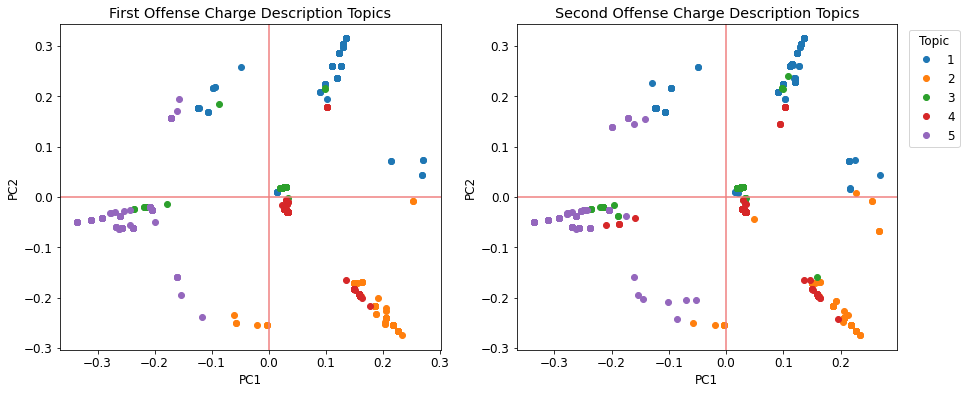

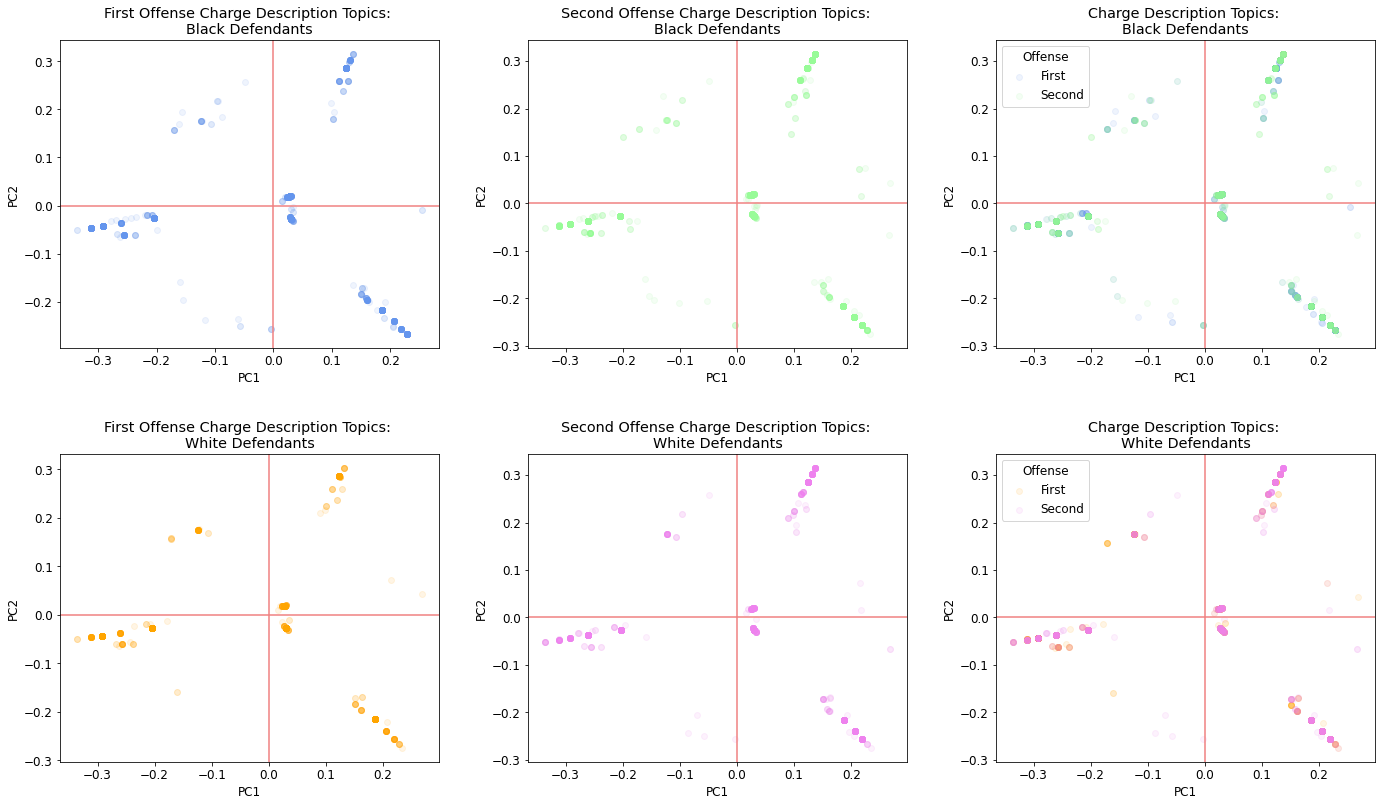

In [101]:
plt.rcParams.update({'font.size': 12})

fig, ax_ = plt.subplots(1, 2)
fig.set_size_inches(15, 6)

groups = first_off_topics_df.groupby("max topic")
for name, group in groups:
    ax_[0].plot(group['PC1'], group['PC2'], marker="o", linestyle="", label=name)
ax_[0].axhline(y=0, color='lightcoral')
ax_[0].axvline(x=0, color='lightcoral')
ax_[0].set_xlabel('PC1')
ax_[0].set_ylabel('PC2')
ax_[0].set_title('First Offense Charge Description Topics')

groups = second_off_topics_df.groupby("max topic")
for name, group in groups:
    ax_[1].plot(group['PC1'], group['PC2'], marker="o", linestyle="", label=name)
ax_[1].legend(title='Topic', bbox_to_anchor=(1.18, 1))
ax_[1].axhline(y=0, color='lightcoral')
ax_[1].axvline(x=0, color='lightcoral')
ax_[1].set_xlabel('PC1')
ax_[1].set_ylabel('PC2')
ax_[1].set_title('Second Offense Charge Description Topics')
plt.show()

bf_xs = b_first_pcs['PC1'].tolist()
bf_ys = b_first_pcs['PC2'].tolist()
bf_labels = b_first_pcs['tokenized description'].tolist()

bs_xs = b_second_pcs['PC1'].tolist()
bs_ys = b_second_pcs['PC2'].tolist()

wf_xs = w_first_pcs['PC1'].tolist()
wf_ys = w_first_pcs['PC2'].tolist()

ws_xs = w_second_pcs['PC1'].tolist()
ws_ys = w_second_pcs['PC2'].tolist()

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 12)

ax[0,0].scatter(bf_xs, bf_ys, alpha=0.1, color='cornflowerblue')
ax[0,0].axhline(y=0, color='lightcoral')
ax[0,0].axvline(x=0, color='lightcoral')
ax[0,0].set_xlabel('PC1')
ax[0,0].set_ylabel('PC2')
ax[0,0].set_title('First Offense Charge Description Topics: \nBlack Defendants')

ax[0,1].scatter(bs_xs, bs_ys, alpha=0.1, color='palegreen')
ax[0,1].axhline(y=0, color='lightcoral')
ax[0,1].axvline(x=0, color='lightcoral')
ax[0,1].set_xlabel('PC1')
ax[0,1].set_ylabel('PC2')
ax[0,1].set_title('Second Offense Charge Description Topics: \nBlack Defendants')

ax[0,2].scatter(bf_xs, bf_ys, alpha=0.1, color='cornflowerblue', label='First')
ax[0,2].scatter(bs_xs, bs_ys, alpha=0.1, color='palegreen', label='Second')
ax[0,2].axhline(y=0, color='lightcoral')
ax[0,2].axvline(x=0, color='lightcoral')
ax[0,2].set_xlabel('PC1')
ax[0,2].set_ylabel('PC2')
ax[0,2].set_title('Charge Description Topics: \nBlack Defendants')
ax[0,2].legend(title='Offense', prop={'size': 12})
fig.tight_layout(pad=3.0)


ax[1,0].scatter(wf_xs, wf_ys, alpha=0.1, color='orange')
ax[1,0].axhline(y=0, color='lightcoral')
ax[1,0].axvline(x=0, color='lightcoral')
ax[1,0].set_xlabel('PC1')
ax[1,0].set_ylabel('PC2')
ax[1,0].set_title('First Offense Charge Description Topics: \nWhite Defendants')

ax[1,1].scatter(ws_xs, ws_ys, alpha=0.1, color='violet')
ax[1,1].axhline(y=0, color='lightcoral')
ax[1,1].axvline(x=0, color='lightcoral')
ax[1,1].set_xlabel('PC1')
ax[1,1].set_ylabel('PC2')
ax[1,1].set_title('Second Offense Charge Description Topics: \nWhite Defendants')

ax[1,2].scatter(wf_xs, wf_ys, alpha=0.1, color='orange', label='First')
ax[1,2].scatter(ws_xs, ws_ys, alpha=0.1, color='violet', label='Second')
ax[1,2].axhline(y=0, color='lightcoral')
ax[1,2].axvline(x=0, color='lightcoral')
ax[1,2].set_xlabel('PC1')
ax[1,2].set_ylabel('PC2')
ax[1,2].set_title('Charge Description Topics: \nWhite Defendants')
ax[1,2].legend(title='Offense', prop={'size': 12})
fig.tight_layout(pad=3.0)
plt.show();

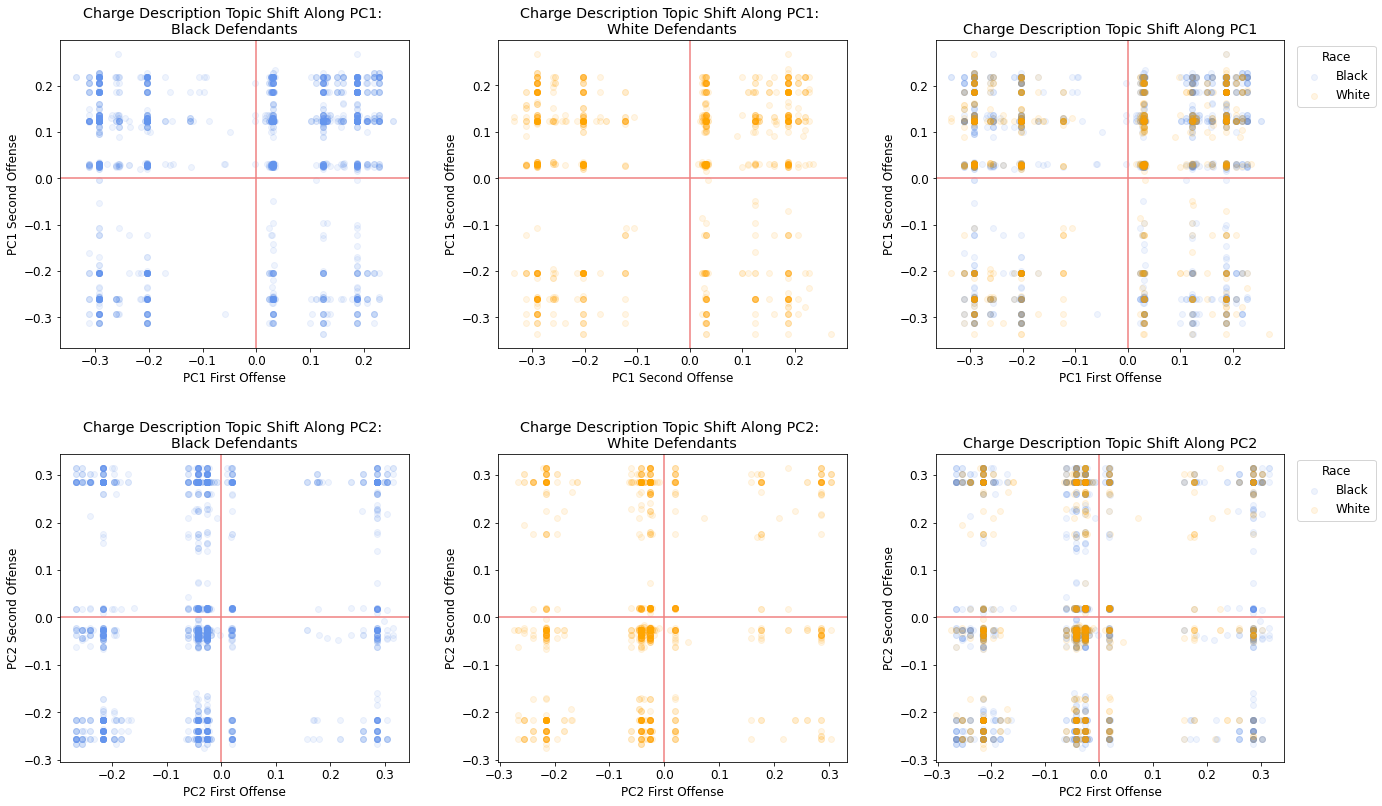

In [102]:
plt.rcParams.update({'font.size': 12})

pc1_bf = b_first_pcs['PC1'].tolist()
pc1_bs = b_second_pcs['PC1'].tolist()
#print('# coords b pc1:', len(pc1_bf))

pc2_bf = b_first_pcs['PC2'].tolist()
pc2_bs = b_second_pcs['PC2'].tolist()
#print('# coords b pc2:', len(pc2_bf))

pc1_wf = w_first_pcs['PC1'].tolist()
pc1_ws = w_second_pcs['PC1'].tolist()
#print('# coords w pc1:', len(pc1_wf))

pc2_wf = w_first_pcs['PC2'].tolist()
pc2_ws = w_second_pcs['PC2'].tolist()
#print('# coords w pc2:', len(pc2_wf))

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 12)

ax[0,0].scatter(pc1_bf, pc1_bs, alpha=0.1, color='cornflowerblue')
ax[0,0].axhline(y=0, color='lightcoral')
ax[0,0].axvline(x=0, color='lightcoral')
ax[0,0].set_xlabel('PC1 First Offense')
ax[0,0].set_ylabel('PC1 Second Offense')
ax[0,0].set_title('Charge Description Topic Shift Along PC1: \nBlack Defendants')

ax[1,0].scatter(pc2_bf, pc2_bs, alpha=0.1, color='cornflowerblue')
ax[1,0].axhline(y=0, color='lightcoral')
ax[1,0].axvline(x=0, color='lightcoral')
ax[1,0].set_xlabel('PC2 First Offense')
ax[1,0].set_ylabel('PC2 Second Offense')
ax[1,0].set_title('Charge Description Topic Shift Along PC2: \nBlack Defendants')

ax[0,1].scatter(pc1_wf, pc1_ws, alpha=0.1, color='orange')
ax[0,1].axhline(y=0, color='lightcoral')
ax[0,1].axvline(x=0, color='lightcoral')
ax[0,1].set_xlabel('PC1 Second Offense')
ax[0,1].set_ylabel('PC1 Second Offense')
ax[0,1].set_title('Charge Description Topic Shift Along PC1: \nWhite Defendants')

ax[1,1].scatter(pc2_wf, pc2_ws, alpha=0.1, color='orange')
ax[1,1].axhline(y=0, color='lightcoral')
ax[1,1].axvline(x=0, color='lightcoral')
ax[1,1].set_xlabel('PC2 First Offense')
ax[1,1].set_ylabel('PC2 Second Offense')
ax[1,1].set_title('Charge Description Topic Shift Along PC2: \nWhite Defendants')


ax[0,2].scatter(pc1_bf, pc1_bs, alpha=0.1, color='cornflowerblue', label='Black')
ax[0,2].scatter(pc1_wf, pc1_ws, alpha=0.1, color='orange', label='White')
ax[0,2].axhline(y=0, color='lightcoral')
ax[0,2].axvline(x=0, color='lightcoral')
ax[0,2].set_xlabel('PC1 First Offense')
ax[0,2].set_ylabel('PC1 Second Offense')
ax[0,2].set_title('Charge Description Topic Shift Along PC1')
ax[0,2].legend(title='Race', bbox_to_anchor=(1.02, 1))

ax[1,2].scatter(pc2_bf, pc2_bs, alpha=0.1, color='cornflowerblue', label='Black')
ax[1,2].scatter(pc2_wf, pc2_ws, alpha=0.1, color='orange', label='White')
ax[1,2].axhline(y=0, color='lightcoral')
ax[1,2].axvline(x=0, color='lightcoral')
ax[1,2].set_xlabel('PC2 First Offense')
ax[1,2].set_ylabel('PC2 Second OFfense')
ax[1,2].set_title('Charge Description Topic Shift Along PC2')
ax[1,2].legend(title='Race', bbox_to_anchor=(1.02, 1), prop={'size': 12})
fig.tight_layout(pad=3.0)

In [39]:
b_idx = np.arange(len(b_first_pcs)).tolist()
w_idx = np.arange(len(w_first_pcs)).tolist()
b_sample_idx = random.sample(b_idx, 1000)
w_sample_idx = random.sample(w_idx, 1000)

# coords b pc1: 1000
# coords b pc2: 1000
# coords w pc1: 1000
# coords w pc2: 1000


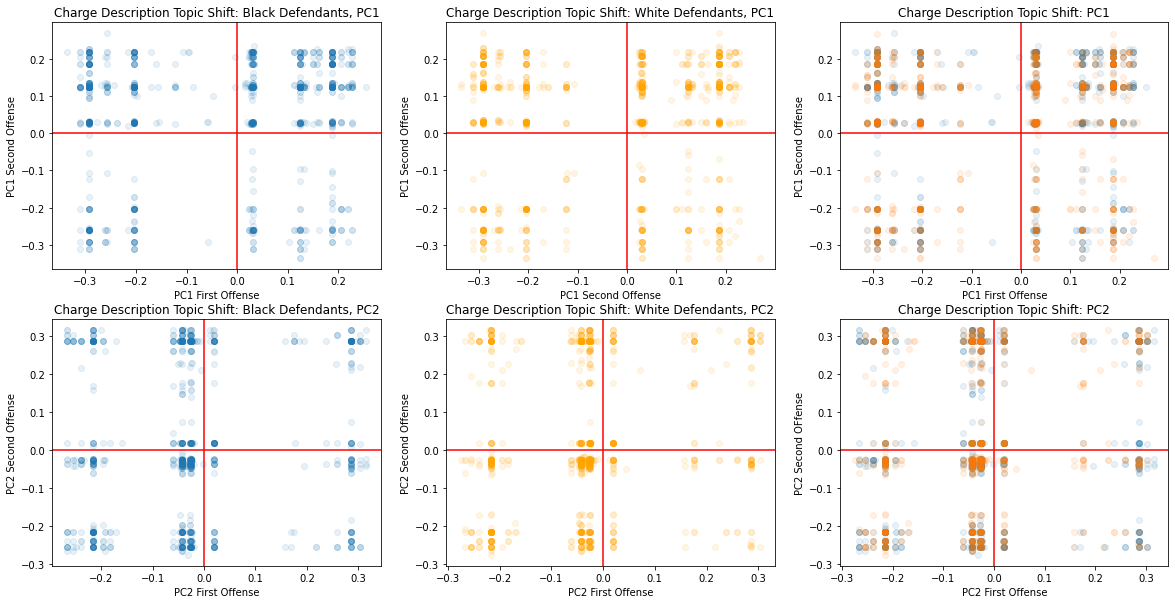

In [40]:
pc1_bf = b_first_pcs['PC1'].tolist()
pc1_bf = [pc1_bf[i] for i in b_sample_idx]
pc1_bs = b_second_pcs['PC1'].tolist()
pc1_bs = [pc1_bs[i] for i in b_sample_idx]
print('# coords b pc1:', len(pc1_bf))

pc2_bf = b_first_pcs['PC2'].tolist()
pc2_bf = [pc2_bf[i] for i in b_sample_idx]
pc2_bs = b_second_pcs['PC2'].tolist()
pc2_bs = [pc2_bs[i] for i in b_sample_idx]
print('# coords b pc2:', len(pc2_bf))

pc1_wf = w_first_pcs['PC1'].tolist()
pc1_wf = [pc1_wf[i] for i in w_sample_idx]
pc1_ws = w_second_pcs['PC1'].tolist()
pc1_ws = [pc1_ws[i] for i in w_sample_idx]
print('# coords w pc1:', len(pc1_wf))

pc2_wf = w_first_pcs['PC2'].tolist()
pc2_wf = [pc2_wf[i] for i in w_sample_idx]
pc2_ws = w_second_pcs['PC2'].tolist()
pc2_ws = [pc2_ws[i] for i in w_sample_idx]
print('# coords w pc2:', len(pc2_wf))

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 10)

ax[0,0].scatter(pc1_bf, pc1_bs, alpha=0.1)
ax[0,0].axhline(y=0, color='red')
ax[0,0].axvline(x=0, color='red')
ax[0,0].set_xlabel('PC1 First Offense')
ax[0,0].set_ylabel('PC1 Second Offense')
ax[0,0].set_title('Charge Description Topic Shift: Black Defendants, PC1')

ax[1,0].scatter(pc2_bf, pc2_bs, alpha=0.1)
ax[1,0].axhline(y=0, color='red')
ax[1,0].axvline(x=0, color='red')
ax[1,0].set_xlabel('PC2 First Offense')
ax[1,0].set_ylabel('PC2 Second Offense')
ax[1,0].set_title('Charge Description Topic Shift: Black Defendants, PC2')

ax[0,1].scatter(pc1_wf, pc1_ws, alpha=0.1, color='orange')
ax[0,1].axhline(y=0, color='red')
ax[0,1].axvline(x=0, color='red')
ax[0,1].set_xlabel('PC1 Second Offense')
ax[0,1].set_ylabel('PC1 Second Offense')
ax[0,1].set_title('Charge Description Topic Shift: White Defendants, PC1')

ax[1,1].scatter(pc2_wf, pc2_ws, alpha=0.1, color='orange')
ax[1,1].axhline(y=0, color='red')
ax[1,1].axvline(x=0, color='red')
ax[1,1].set_xlabel('PC2 First Offense')
ax[1,1].set_ylabel('PC2 Second Offense')
ax[1,1].set_title('Charge Description Topic Shift: White Defendants, PC2')


ax[0,2].scatter(pc1_bf, pc1_bs, alpha=0.1)
ax[0,2].scatter(pc1_wf, pc1_ws, alpha=0.1)
ax[0,2].axhline(y=0, color='red')
ax[0,2].axvline(x=0, color='red')
ax[0,2].set_xlabel('PC1 First Offense')
ax[0,2].set_ylabel('PC1 Second Offense')
ax[0,2].set_title('Charge Description Topic Shift: PC1')

ax[1,2].scatter(pc2_bf, pc2_bs, alpha=0.1)
ax[1,2].scatter(pc2_wf, pc2_ws, alpha=0.1)
ax[1,2].axhline(y=0, color='red')
ax[1,2].axvline(x=0, color='red')
ax[1,2].set_xlabel('PC2 First Offense')
ax[1,2].set_ylabel('PC2 Second OFfense')
ax[1,2].set_title('Charge Description Topic Shift: PC2');

In [ ]:
# find avg PC1 change for groups
# find avg PC2 change for groups

In [41]:
cr_topics_common[cr_topics_common['id']==3]

,id,charge type,name,race,charge description,tokenized description,max topic,PC1,PC2,t1,t2,t3,t4,t5
1,3,C,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,0.028595,0.019102,0.02265,0.018484,0.925910,0.011355,0.021600
1,3,R,kevon dixon,African-American,Felony Battery (Dom Strang),"[feloni, batteri, domest, strangul]",3,0.028597,0.019102,0.02265,0.018484,0.925911,0.011355,0.021599


In [42]:
c_pcs_df = cr_topics_common[cr_topics_common['charge type']=='C'][['PC1', 'PC2']]
c_pcs = np.array([list(c_pcs_df.PC1), list(c_pcs_df.PC2)]).T
r_pcs_df = cr_topics_common[cr_topics_common['charge type']=='R'][['PC1', 'PC2']]
r_pcs = np.array([list(r_pcs_df.PC1), list(r_pcs_df.PC2)]).T

In [43]:
pc_shift = r_pcs - c_pcs
print(c_pcs[0])
print(r_pcs[0])

[0.02859528 0.01910191]
[0.02859727 0.01910228]


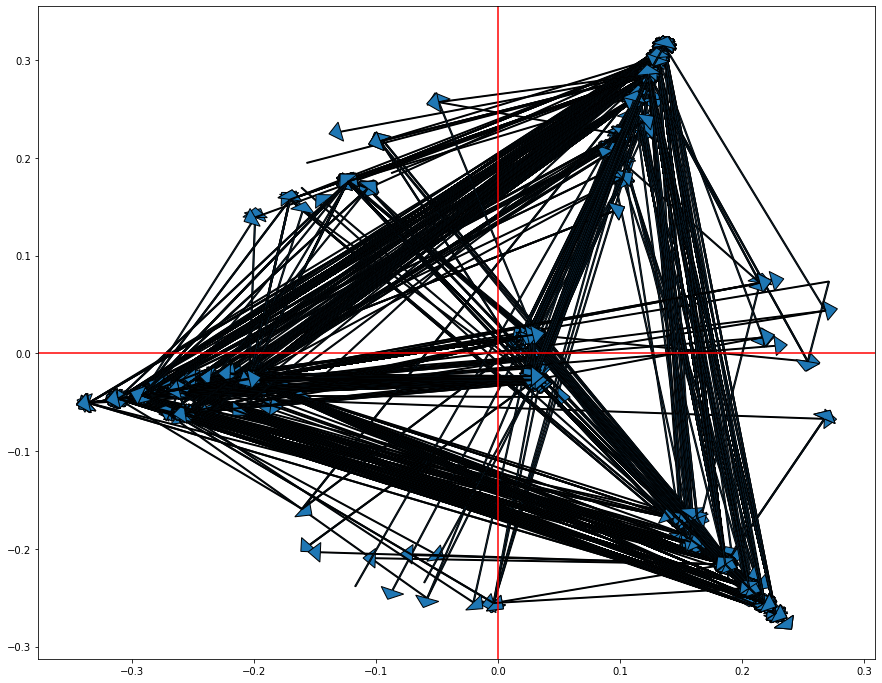

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 12)
for i in range(pc_shift.shape[0]):
    x = c_pcs[i][0]
    y = c_pcs[i][1]
    dx = pc_shift[i][0]
    dy = pc_shift[i][1]
    ax.arrow(x, y, dx, dy, head_width=0.02, head_length=0.01)

plt.axhline(y=0, color='red')
plt.axvline(x=0, color='red')

In [45]:
b_c_pcs_df = cr_topics_common[(cr_topics_common['charge type']=='C') & (cr_topics_common['race']=='African-American')][['PC1', 'PC2']]
b_c_pcs = np.array([list(b_c_pcs_df.PC1), list(b_c_pcs_df.PC2)]).T
b_r_pcs_df = cr_topics_common[(cr_topics_common['charge type']=='R') & (cr_topics_common['race']=='African-American')][['PC1', 'PC2']]
b_r_pcs = np.array([list(b_r_pcs_df.PC1), list(b_r_pcs_df.PC2)]).T

In [46]:
b_pc_shift = b_r_pcs - b_c_pcs

274


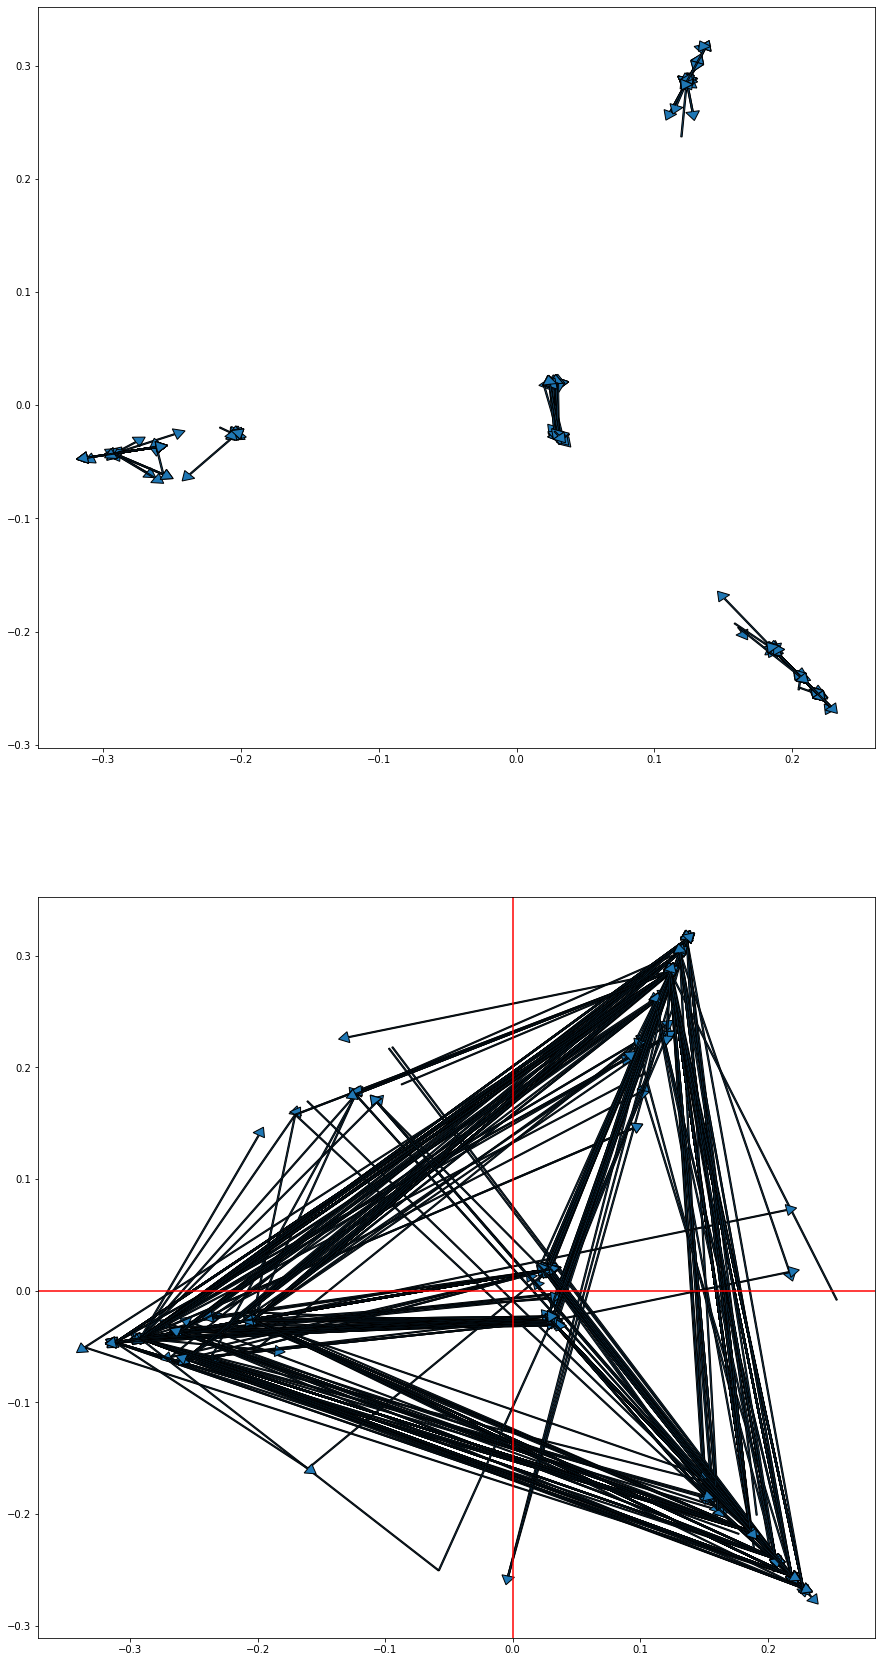

In [47]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 30)
ct = 0
sm_movement = 0
lg_movement = 0
for i in range(0, 1000):
    x = b_c_pcs[i][0]
    y = b_c_pcs[i][1]
    dx = b_pc_shift[i][0]
    dy = b_pc_shift[i][1]
    if ((x + dx) > 0 and (x + dx) < 0.1):
        if ((y + dy) > -0.1 and (y + dy) < 0.1):
            ct += 1
    if (abs(dx) < 0.05) and (abs(dy) < 0.05):
        ax[0].arrow(x, y, dx, dy, head_width=0.01, head_length=0.008)
        sm_movement += 1
    else:
        ax[1].arrow(x, y, dx, dy, head_width=0.01, head_length=0.008)
        lg_movement += 1
        
plt.axhline(y=0, color='red')
plt.axvline(x=0, color='red')
print(sm_movement)

In [48]:
w_c_pcs_df = cr_topics_common[(cr_topics_common['charge type']=='C') & (cr_topics_common['race']=='Caucasian')][['PC1', 'PC2']]
w_c_pcs = np.array([list(w_c_pcs_df.PC1), list(w_c_pcs_df.PC2)]).T
w_r_pcs_df = cr_topics_common[(cr_topics_common['charge type']=='R') & (cr_topics_common['race']=='Caucasian')][['PC1', 'PC2']]
w_r_pcs = np.array([list(w_r_pcs_df.PC1), list(w_r_pcs_df.PC2)]).T

In [49]:
w_pc_shift = w_r_pcs - w_c_pcs
print(w_c_pcs[0])
print(w_r_pcs[0])
np.mean(pc_shift)

[ 0.20609694 -0.24000266]
[ 0.21874706 -0.25540546]


0.07477580849239938

265


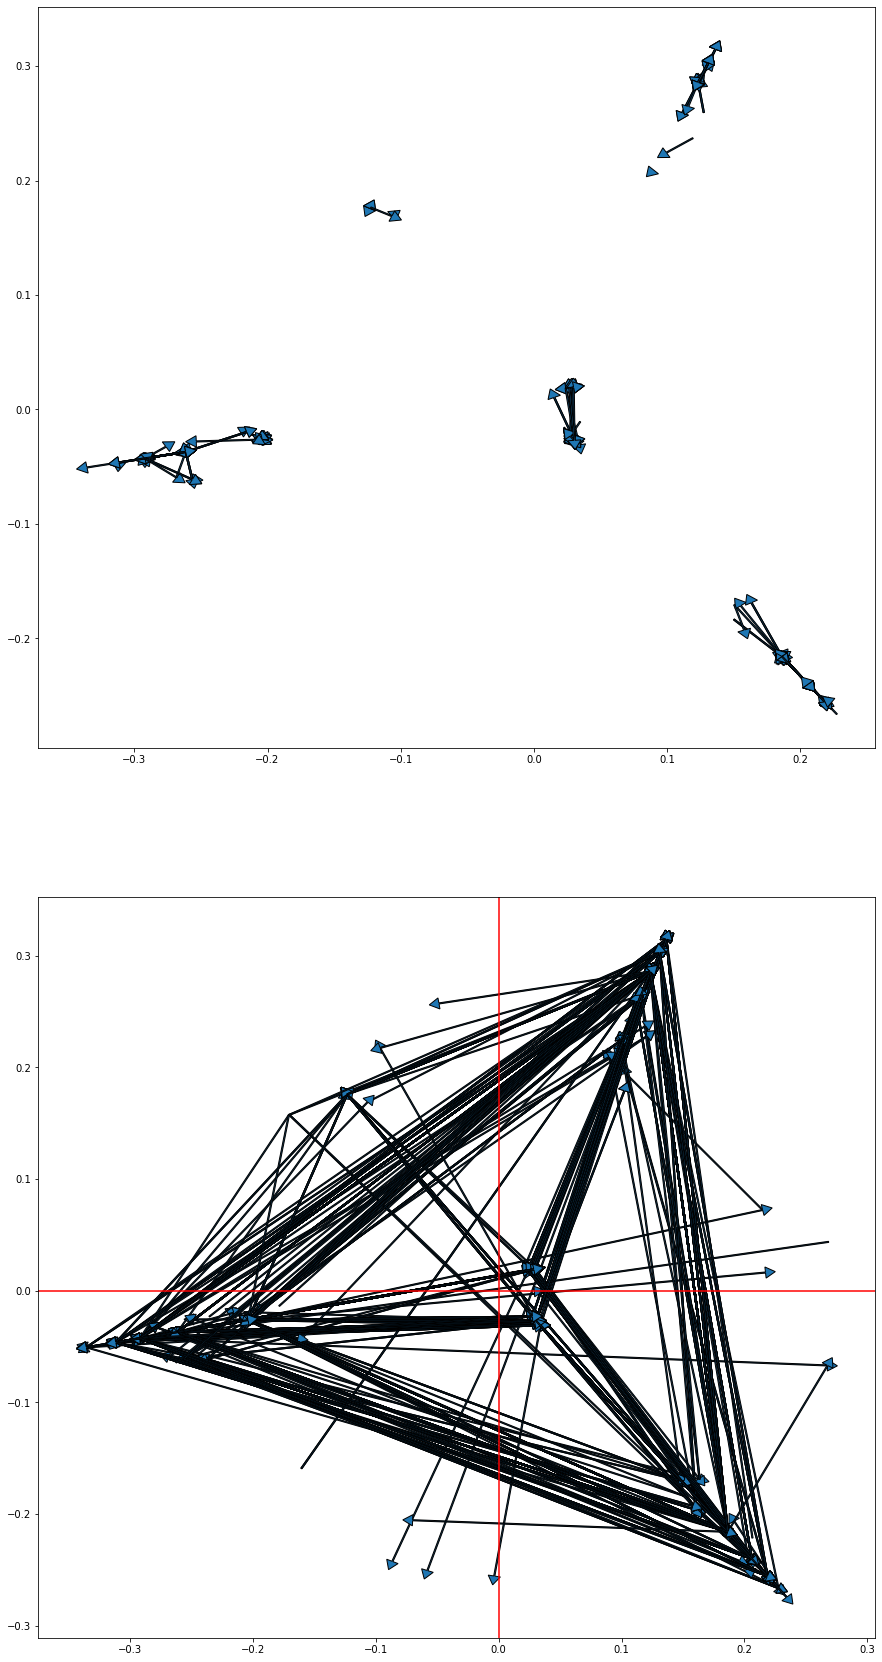

In [50]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 30)
ct = 0
w_sm_movement = 0
w_lg_movement = 0
for i in range(0, w_pc_shift.shape[0]):
    x = w_c_pcs[i][0]
    y = w_c_pcs[i][1]
    dx = w_pc_shift[i][0]
    dy = w_pc_shift[i][1]
    if ((x + dx) > 0 and (x + dx) < 0.1):
        if ((y + dy) > -0.1 and (y + dy) < 0.1):
            ct += 1
    if (abs(dx) < 0.05) and (abs(dy) < 0.05):
        ax[0].arrow(x, y, dx, dy, head_width=0.01, head_length=0.008)
        w_sm_movement += 1
    else:
        ax[1].arrow(x, y, dx, dy, head_width=0.01, head_length=0.008)
        w_lg_movement += 1
        
plt.axhline(y=0, color='red')
plt.axvline(x=0, color='red')
print(w_sm_movement)